In [1]:
import quandl

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import requests
# Json: to format as json calls to API
import json 
# Pandas: to plot the timeseries
import pandas as pd
# Datetime: to convert different date formats
import datetime as dt
# Import the Time Series library
import statsmodels.tsa.stattools as ts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
#%matplotlib inline
import hdbscan
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl


def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.figsize = (8,8)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels, palette

In [56]:
#gold price USD from Quandl (deutsche bank bundesbank data repository)

import yfinance as yf
Df = yf.download('GLD', "2018-02-09", "2020-10-28", auto_adjust=True)
gold = Df[['Open']]
# Drop rows with missing values
gold = gold['Open'].dropna()

#s and p 500 index, need to change the dates you want it for
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2018, 2, 9)
end = datetime.datetime(2020, 10, 27)
SP500 = web.DataReader(['sp500'], 'fred', start, end)
sp=SP500['sp500'].dropna()

#bitcoin price, only reall useful post 2017
btc=quandl.get("BCHAIN/MKPRU", authtoken="1sdgFhvRwseGzDfVUZSL", start_date="2018-02-09", end_date="2020-10-27")
btc=btc['Value']

[*********************100%***********************]  1 of 1 completed



In [57]:
date = pd.DataFrame(columns=['date'])
date['date'] = sp.index.copy()

date_g = pd.DataFrame(columns=['date'])
date_g['date'] = gold.index.copy()

date_btc = pd.DataFrame(columns=['date'])
date_btc['date'] = btc.index.copy()

#excluding weekends for BTC - only business days
df=pd.DataFrame({'date':btc.index, 'val':btc.values})
a=date_g['date']
btc = df[df['date'].isin(a)]


Text(0.5, 0, 'Date')

Text(0.5, 0, 'Date')

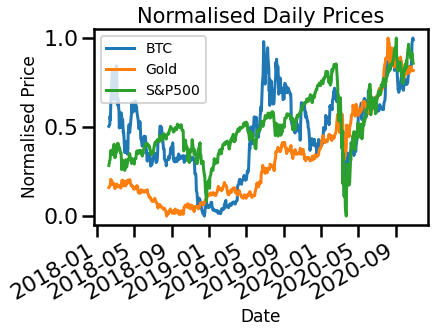

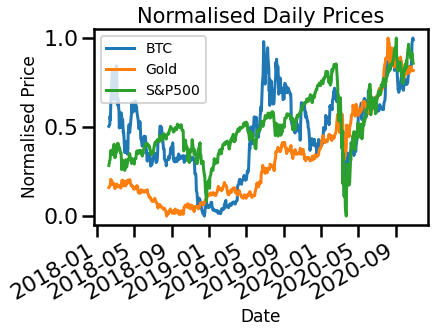

In [58]:
#normalising all prices

#s and p
norm_sp=[]
for i in sp:
    norm_sp.append((i-sp.min())/(sp.max()-sp.min()))

#gold
norm_g=[]
for j in gold:
    norm_g.append((j-gold.min())/(gold.max()-gold.min()))

#BTC
norm_btc=[]
for k in btc['val']:
    norm_btc.append((k-btc['val'].min())/(btc['val'].max()-btc['val'].min()))

    
fig1, ax = plt.subplots()
ax.plot(btc['date'],norm_btc, label="BTC")
ax.plot(date_g,norm_g, label="Gold")
ax.plot(date,norm_sp, label="S&P500")

# rotate and align the tick labels so they look better
fig1.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('fig1.autofmt_xdate fixes the labels')    

plt.legend(loc="upper left")
plt.title('Normalised Daily Prices', fontsize=21)
plt.ylabel('Normalised Price', fontsize=17)
plt.xlabel('Date',fontsize=17)




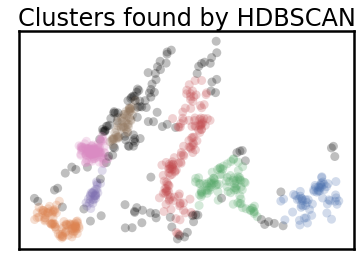

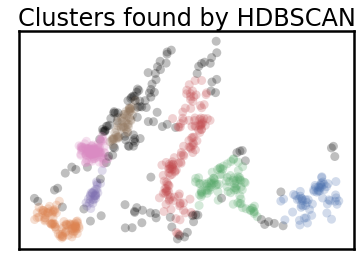

In [15]:
#dimensionality reduction and HDBSCAN clustering

price_df=pd.DataFrame({"gold P":pd.Series(norm_g), "btc P":pd.Series(norm_btc), "sp P":pd.Series(norm_sp)})
price_df.set_index(date['date'], inplace = True)
data_array = (price_df).to_numpy()

data_array
# n components = 2 from the above analysis, BUT it can be derived
# from the data
pca = PCA(n_components=2).fit(data_array)
pca_2d = pca.transform(data_array)
#the data here is us comprasing higher D data into 2d so we can plot a simple graphic, while 
#encompassing all information needed
data = pca_2d.copy()

#@title Minimum business days per cluster
cluster_size = 9 #@param {type:"slider", min:0, max:100, step:1}

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
    
price_df['clusters'], colors = plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':cluster_size})     
cluster_labels = set(price_df)


In [16]:
# kmeans clustering

data = pca_2d.copy()    
plot_clusters(data, cluster.KMeans, (), {'n_clusters':5})


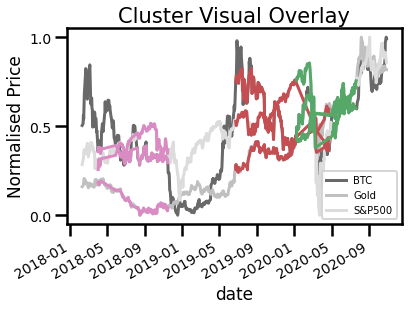

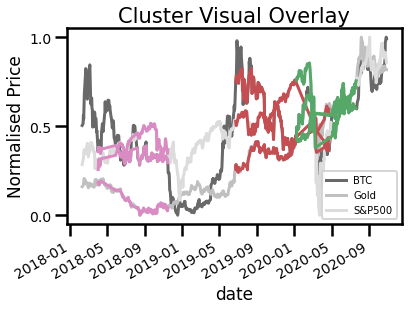

In [38]:
#visualising clusters
fig, ax1 = plt.subplots()
pd.Series(norm_btc, index = btc['date']).plot(ax = ax1, style ='-',color='dimgray',label='BTC')
pd.Series(norm_g, index = btc['date']).plot(ax = ax1, style ='-',color='silver', label='Gold')
pd.Series(norm_sp, index = btc['date']).plot(ax = ax1, style ='-',color='gainsboro', label='S&P500')
plt.xlabel('Date', fontsize=17)
plt.ylabel('Normalised Price', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rc('legend',fontsize=10)
plt.legend(loc="lower right")
plt.title('Cluster Visual Overlay', fontsize=21)

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 10)
number = len(cluster_labels)
top_clusters = number
number = top_clusters
cmap = plt.get_cmap('gnuplot')

cluster_freq = np.unique(price_df['clusters'], return_counts=True)
df_cf_t = pd.DataFrame([cluster_freq[0],cluster_freq[1]])
df_cf = (df_cf_t.transpose()).sort_values([1],ascending = False) 
i = 0
#for cluster_label in cluster_labels:
for i in range(0,top_clusters):
    cluster_label = df_cf.iloc[i][0]
    if (cluster_label >= 0):
        pd.Series(norm_btc, index = btc['date'])[price_df['clusters'] == cluster_label].plot(ax = ax1, color = colors[cluster_label])
        pd.Series(norm_g, index = btc['date'])[price_df['clusters'] == cluster_label].plot(ax = ax1, color = colors[cluster_label])
        pd.Series(norm_sp, index = btc['date'])[price_df['clusters'] == cluster_label].plot(ax = ax1, color = colors[cluster_label])

[*********************100%***********************]  1 of 1 completed



Text(0.5, 1.0, '20-Day Trailing Volatility')

Text(0.5, 1.0, '20-Day Trailing Volatility')

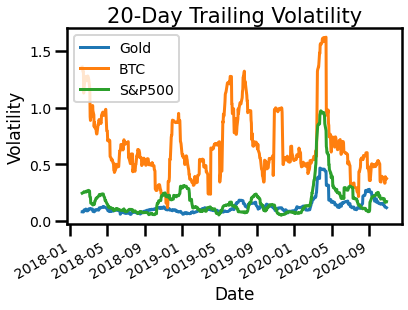

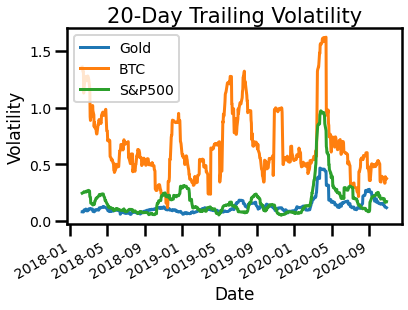

In [59]:

#loading new data, which has 20 more data points so the dates can match with the other data set for normalised prices
Df = yf.download('GLD', "2018-01-11", "2020-10-28", auto_adjust=True)
gold = Df[['Open']]
gold_NEW = gold['Open'].dropna()

start = datetime.datetime(2018, 1, 11)
end = datetime.datetime(2020, 10, 27)
SP500 = web.DataReader(['sp500'], 'fred', start, end)
sp_NEW=SP500['sp500'].dropna()

btc=quandl.get("BCHAIN/MKPRU", authtoken="1sdgFhvRwseGzDfVUZSL", start_date="2018-01-11", end_date="2020-10-27")
btc_new=btc['Value']

date_g = pd.DataFrame(columns=['date'])
date_g['date'] = gold_NEW.index.copy()


#making dates match, btc trades through weekends, gold and s and p dont...
btc_new
df=pd.DataFrame({'date':btc_new.index, 'val':btc_new.values})
a=date_g['date']
df = df[df['date'].isin(a)]

#finding the 20 day moving vol for each, with the SAME days, then plotting
vol=gold_NEW.pct_change().rolling(20).std()*(252**0.5)
vol=vol["2018-02-09":]
vol.plot(label="Gold")

vol1=df['val'].pct_change().rolling(20).std()*(252**0.5)
vol1=vol1[20:]
plt.plot(df['date'][20:],vol1, label="BTC")

vol2=sp_NEW.pct_change().rolling(20).std()*(252**0.5)
vol2=vol2["2018-02-09":]
vol2.plot(label="S&P500")


plt.legend(loc="upper left")
plt.title('20 Day Trailing Volatility')
plt.ylabel('Volatiltiy')
plt.xlabel('Date')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Volatility', fontsize=17)
plt.rc('legend',fontsize=14)
plt.legend(loc="upper left")
plt.title('20-Day Trailing Volatility', fontsize=21)




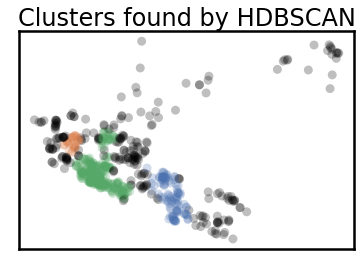

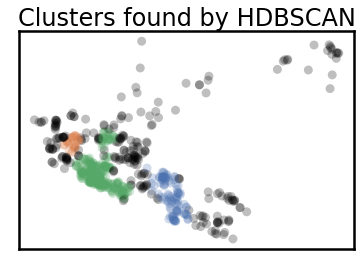

In [46]:
vol_df=pd.DataFrame({"gold vol":vol.values, "btc vol":vol1, "sp vol":vol2.values})
vol_df.set_index(df['date'][20:], inplace = True)
data_array = (vol_df).to_numpy()

# n components = 2 from the above analysis, BUT it can be derived
# from the data
pca = PCA(n_components=2).fit(data_array)
pca_2d = pca.transform(data_array)
data = pca_2d.copy()

#@title Minimum business days per cluster
cluster_size = 27 #@param {type:"slider", min:0, max:100, step:1}

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
    
vol_df['clusters'], colors = plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':cluster_size})     
cluster_labels = set(vol_df)



In [50]:
# kmeans clustering
data = pca_2d.copy()    
plot_clusters(data, cluster.KMeans, (), {'n_clusters':4})


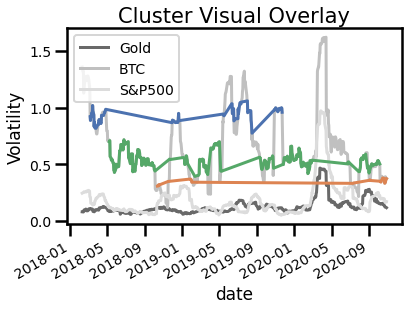

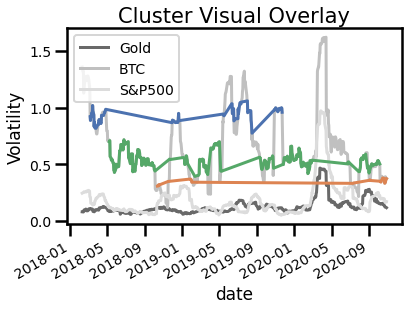

In [54]:
#visualising clusters
fig, ax = plt.subplots()
pd.Series(vol.values, index = df['date'][20:]).plot(ax = ax, style ='-',color='dimgray',label='Gold')
pd.Series(vol1.values, index = df['date'][20:]).plot(ax = ax, style ='-', color='silver', label='BTC')
pd.Series(vol2.values, index = df['date'][20:]).plot(ax = ax, style ='-', color='gainsboro', label='S&P500')


plt.xlabel('Date', fontsize=17)
plt.ylabel('Volatility', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rc('legend',fontsize=14)
plt.legend(loc="upper left")
plt.title('Cluster Visual Overlay', fontsize=21)


x = np.linspace(0, 1, 10)
number = len(cluster_labels)
top_clusters = number
number = top_clusters
cmap = plt.get_cmap('gnuplot')

cluster_freq = np.unique(vol_df['clusters'], return_counts=True)
df_cf_t = pd.DataFrame([cluster_freq[0],cluster_freq[1]])
df_cf = (df_cf_t.transpose()).sort_values([1],ascending = False) 
i = 0
#for cluster_label in cluster_labels:
for i in range(0,top_clusters):
    cluster_label = df_cf.iloc[i][0]
    if (cluster_label >= 0):
#         pd.Series(vol.values, index = df['date'][20:])[vol_df['clusters'] == cluster_label].plot(ax = ax, color = colors[cluster_label])
        pd.Series(vol1.values, index = df['date'][20:])[vol_df['clusters'] == cluster_label].plot(ax = ax,color = colors[cluster_label])
#         pd.Series(vol2.values, index = df['date'][20:])[vol_df['clusters'] == cluster_label].plot(ax = ax, color = colors[cluster_label])

In [ ]:
# prices=[]
# for i in sp:
#     prices.append(i)
# import numpy as np
# prices=np.array(prices).T
# prices=prices.reshape(1, -1)
# prices

# from sklearn.preprocessing import Normalizer
# normalizer = Normalizer() # Define a Normalizer
# norm_movements = normalizer.fit_transform(prices)

# date = pd.DataFrame(columns=['date'])
# date['date'] = sp.index.copy()

# for i in norm_movements:
#     norm_movements=i

# plt.plot(date,norm_movements)